## Train val comparison

Create detailed comparisons between tanimioto similarity in datasets and molecules

In [37]:
from typing import List
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

from mist.utils.plot_utils import * 
from PIL import Image


from mist import utils
set_style()


In [38]:
# Get pairwise similarity for each smiles with rdkit
# Use bulk all chem diff function
def pairwise_smiles_tanimoto_sim(smiles_list: List[str]):
    """
    Compute pairwise tanimoto similarity for a list of smiles
    """
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) 
           for mol in mols]
    out_ar = []
    for fp in tqdm(fps):
        bulk_output_temp = np.asarray(Chem.DataStructs.BulkTanimotoSimilarity(fp, fps))
        out_ar.append(bulk_output_temp)
    # Stack and return
    return np.stack(out_ar)

In [39]:
split_name = "canopus_hplus_100" #"csi_split"
dataset = "canopus_train" #csi2022"
ext = ".csv" # ".txt"

# split_name = "csi_split"
# dataset = "csi2022" #"csi2022"
# ext=".txt"

split_num = 0

data_path = Path(f"../data/paired_spectra/{dataset}")
labels_file = data_path / "labels.tsv"
split_file = data_path / f"splits/{split_name}_{split_num}{ext}"
save_folder = Path("../results/2023_05_03_data_split_investigation")
save_folder.mkdir(exist_ok=True, parents=True)

In [40]:
# Load the labels
labels_df = pd.read_csv(labels_file, sep="\t")

# Load the split as csv
split_df = pd.read_csv(split_file, sep=",")
# split df has two keys 'name' and a second determining fold
# Extract the fold name
spec_key = "name"
split_key = list(set(split_df.keys()).difference([spec_key]))[0]

# Get the spectra names in each set
train_names = split_df[split_df[split_key] == "train"][spec_key].values
val_names = split_df[split_df[split_key] == "val"][spec_key].values
test_names = split_df[split_df[split_key] == "test"][spec_key].values

In [41]:
# Map spectra names to smiles
spec_to_smiles = dict(zip(labels_df['spec'].values, labels_df['smiles']))

In [42]:
all_spec, all_smis = zip(*list(spec_to_smiles.items()))
spec_to_ind = dict(zip(all_spec, range(len(all_spec))))

In [43]:
sim_mat = pairwise_smiles_tanimoto_sim(all_smis)

100%|██████████| 10709/10709 [00:13<00:00, 804.54it/s]


In [44]:
print(sim_mat.shape)
# Zero diagonal of sim mat
np.fill_diagonal(sim_mat, 0)

(10709, 10709)


In [45]:
# Get the most similar mol in train for each item in train
train_inds = [spec_to_ind[name] for name in train_names]
train_sub_sim = sim_mat[:, train_inds]


In [46]:
# Highest similarity to train
highest_train_sim = train_sub_sim.max(1)
# highest_train_sim = train_sub_sim.mean(1)

In [47]:
train_inds = [spec_to_ind[name] for name in train_names]
val_inds = [spec_to_ind[name] for name in val_names]
test_inds = [spec_to_ind[name] for name in test_names]

In [48]:
train_high_sim = highest_train_sim[train_inds]
val_high_sim = highest_train_sim[val_inds]
test_high_sim = highest_train_sim[test_inds]

In [49]:
# Check where / why we get max sim of 1 to train
np.where(test_high_sim == 1)[0].flatten()

array([ 15, 109, 230, 251, 433, 500, 504, 506, 516, 519, 530, 560, 656,
       679, 741, 758])

In [50]:
spec_ind = test_inds[15]
sim_ind = train_inds[np.argmax(train_sub_sim[spec_ind, :])]
invest_spec = all_spec[spec_ind]
compare_spec = all_spec[sim_ind]
print(invest_spec in test_names, invest_spec in train_names)
print(compare_spec in test_names, compare_spec in train_names)

True False
False True


In [51]:
# Get inchikeys for each of these
invest_inchi = labels_df[labels_df['spec'] == invest_spec]['inchikey'].values[0]
compare_inchi = labels_df[labels_df['spec'] == compare_spec]['inchikey'].values[0]
print(invest_inchi, compare_inchi)

DCIHLTIBNFDPMW-UHFFFAOYSA-N VQQFJLCUEFKGHJ-UHFFFAOYSA-N


CCCCCCCCCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCCCC)COP(=O)(O)OCCN CCCCCCCCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCCC)COP(=O)(O)OCCN


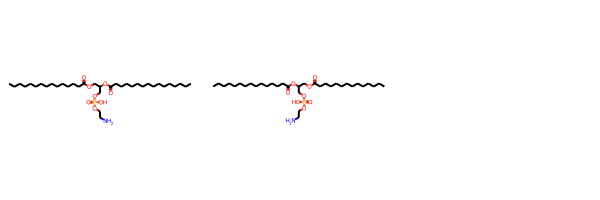

In [52]:
# Draw both compounds
invest_mol = Chem.MolFromSmiles(spec_to_smiles[invest_spec])
compare_mol = Chem.MolFromSmiles(spec_to_smiles[compare_spec])
# Print smiles
print(spec_to_smiles[invest_spec], spec_to_smiles[compare_spec])
Draw.MolsToGridImage([invest_mol, compare_mol])


In [53]:
pairwise_smiles_tanimoto_sim([spec_to_smiles[invest_spec], spec_to_smiles[compare_spec]])

100%|██████████| 2/2 [00:00<00:00, 22489.57it/s]


array([[1., 1.],
       [1., 1.]])

In [54]:
train_high_sim.mean(), val_high_sim.mean(), test_high_sim.mean()

(0.7124671901246425, 0.709178116701234, 0.6553776970022508)

Average max tani similarity across train,val, test:  
CSI: 0.6887733699912633, 0.6917309089156306, 0.630679569871384  
Canopus: (0.7124671901246425, 0.709178116701234, 0.6553776970022508)



Canopus diff split mols: CCCCCCCCCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCCCC)COP(=O)(O)OCCN CCCCCCCCCCCCCCC(=O)OC(COC(=O)CCCCCCCCCCCCC)COP(=O)(O)OCCN


/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


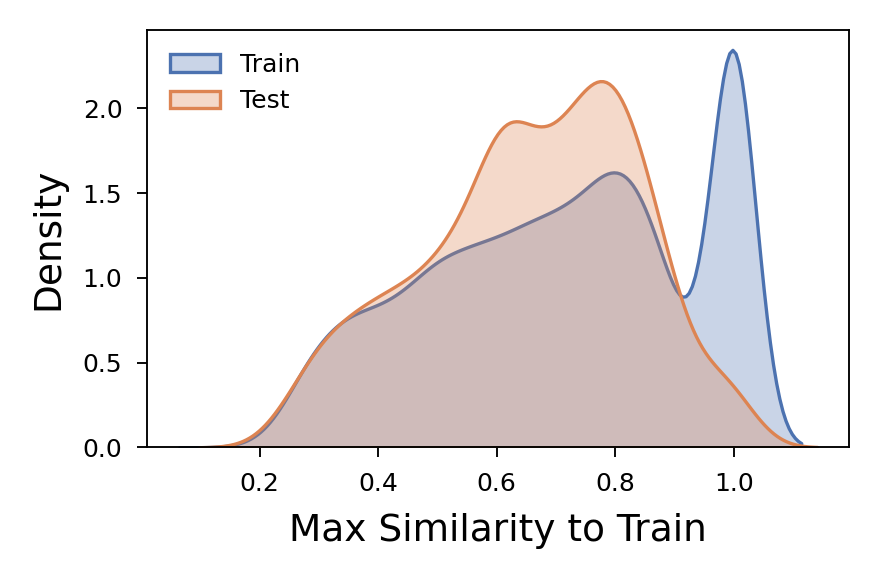

In [55]:
# Plot histograms of highest similarity for each 
# Also plot vertical lines for mean of each distribution
# Make sure to use separate distinct colors and higher alpha to vizualize
# Make them aesthecially appealing and look pretty
# Also set size so that it's visible in a paper figure
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_subplot(111)

# Plot distplots for each 
# Use better colors
# Fill plots
sns.distplot(train_high_sim, bins=25, label="Train", ax=ax,kde=True, norm_hist=True, 
             kde_kws={"shade":True, "alpha":0.3}, hist=False)
sns.distplot(test_high_sim, bins=25, label="Test", ax=ax, kde=True, norm_hist=True,
             kde_kws={"shade":True, "alpha":0.3}, hist=False)

# Define legend in upper left and without any border or fill
ax.legend(loc="upper left", frameon=False, facecolor=None, edgecolor=None)
ax.set_xlabel("Max Similarity to Train")
ax.set_ylabel("Density")
plt.tight_layout()
plt.savefig(save_folder / f"highest_sim_to_train_{dataset}.pdf", dpi=300, bbox_inches="tight")

## Single molecule distribution shift
Pick a single training split and determine the closest molecule in a new set to that old example

In [20]:
# Get pairwise similarity for each smiles with rdkit
# Use bulk all chem diff function
def pairwise_smiles_tanimoto_sim(smi_list1: List[str], smi_list2):
    """
    Compute pairwise tanimoto similarity for a list of smiles
    """
    mols1 = [Chem.MolFromSmiles(smi) for smi in smi_list1]
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) 
           for mol in mols1]

    mols2 = [Chem.MolFromSmiles(smi) for smi in smi_list2]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) 
           for mol in mols2]


    out_ar = []
    for fp in tqdm(fps1):
        bulk_output_temp = np.asarray(Chem.DataStructs.BulkTanimotoSimilarity(fp, fps2))
        out_ar.append(bulk_output_temp)
    # Stack and return
    return np.stack(out_ar)

In [21]:
# Retrospective
split_name = "csi_split_0.txt"
dataset = "csi2022"
num_to_smi = {
    1: r"O=C(O)C1CCN(C(COC2=CC3=C(C4=CC=CC=C4C(O3)=O)C=C2)=O)CC1",
    2: r"COC1=C(OC)C(OC)=C(/C=C2C(C3=C(C=C(OCC(N4CCC(C(O)=O)CC4)=O)C=C3)O\2)=O)C=C1",
    3: r"CCOC(C(NC(COC1=CC=C(Br)C=C1)=O)CC2=CNC3=CC=CC=C32)=O",
    4: r"CC1=C(C(NC(C(O)=O)CC2=CNC3=CC=CC=C32)=O)C=C(C4=CC=CC=C4)O1"
}
neighb_name = "contrast_neighbors"

# # Prospective
# split_name = "prospective_split.csv"
# dataset = "csi2022"
# num_to_smi = {
#     5: r"CC(C(C(NC(C(O)C)C(O)=O)=O)N)C",
#     6: r"CCC(C(C(NC(C(O)C)C(O)=O)=O)N)C",
#     7: r"CCC(C(N)C(NC(C(O)=O)CC(N)=O)=O)C",
#     8: r"NC(C(N1CCCC1C(N2CCCC2C(O)=O)=O)=O)CCC(O)=O",
#     9: r"O=C(C(N)CC(O)=O)N1C(C(O)=O)CCC1",
#     10: r"NC(C(O)=O)CCCC(C(O)=O)NC(CCC(C(O)=O)N)=O",
#     11: r"NC(C(O)=O)CCC/N=C1NC(C(N\1)CC(C(CO)O)O)=O",
#     12: r"CCCCCC(C(NC(C(N1CCCC1CO)=O)C(C)C)=O)CC(NO)=O",
#     13: r"NCC(N1CCCC1C(NCC(N)=O)=O)=O",
#     14: r"O=C(CN)N1C(C(NC(C(O)=O)CCC/N=C(N)/N)=O)CCC1",
# }
# neighb_name = "prospective_mols_1"

# # Prospective
split_name = "prospective_split.csv"
dataset = "csi2022"
num_to_smi = {
    15: r"O=C(C1=CC=NC=C1)O",
    16: r"CC1(CC(CC(C)(N1)C)=O)C",
    17:r"O=C(N1CCCCC1)/C=C/C=C/C=C/C2=CC(OCO3)=C3C=C2",
    18:  r"C/C=C/CC(C(O)=O)NC(C1=C(CCC)C(C(C)=O)=C(C)N1)=O",

}
neighb_name = "prospective_mols_2"



data_path = Path(f"../data/paired_spectra/{dataset}")
labels_file = data_path / "labels.tsv"
split_file = data_path / f"splits/{split_name}"
save_folder = Path("../results/2023_05_05_mol_comparisons")
save_folder.mkdir(exist_ok=True, parents=True)

In [32]:
# Load the labels
labels_df = pd.read_csv(labels_file, sep="\t")

# Load the split as csv
split_df = pd.read_csv(split_file, sep=",")
# split df has two keys 'name' and a second determining fold
# Extract the fold name
spec_key = "name"
split_key = list(set(split_df.keys()).difference([spec_key]))[0]

# Get the spectra names in each set
train_names = split_df[split_df[split_key] == "train"][spec_key].values
val_names = split_df[split_df[split_key] == "val"][spec_key].values
test_names = split_df[split_df[split_key] == "test"][spec_key].values

# Map spectra names to smiles
spec_to_smiles = dict(zip(labels_df['spec'].values, labels_df['smiles']))
train_smis = [spec_to_smiles[name] for name in train_names]

smi_to_num = {v: k for k, v in num_to_smi.items()}
smi_to_mol = {smi: Chem.MolFromSmiles(smi) for smi in num_to_smi.values()}

key_list = sorted(list(num_to_smi.keys()))
smi_list = [num_to_smi[k] for k in key_list]

In [34]:
# Pairwise sim from smiles to dataset
pairwise_sim = pairwise_smiles_tanimoto_sim(smi_list, train_smis)

# Max sim
max_sim = pairwise_sim.max(axis=1)

# Identify the ind for the nearest neighbor in train
max_sim_ind = pairwise_sim.argmax(axis=1)
# Get the nearest neighbor smiles
max_sim_smi = [train_smis[ind] for ind in max_sim_ind]
# Make a dict with this mapping
smi_to_max_sim_smi = dict(zip(smi_list, max_sim_smi))

# Create dataframe with num, smi, nearest smi, and max sim 
df_list = []
for smi in smi_list:
    df_list.append({
        "num": smi_to_num[smi],
        "smi": smi,
        "max_sim_smi": smi_to_max_sim_smi[smi],
        "max_sim": max_sim[smi_list.index(smi)]
    })
df = pd.DataFrame(df_list)
df

100%|██████████| 4/4 [00:00<00:00, 228.54it/s]


,num,smi,max_sim_smi,max_sim
0,15,O=C(C1=CC=NC=C1)O,C1=CN=CC=C1C(=O)O,1.000000
1,16,CC1(CC(CC(C)(N1)C)=O)C,CC1(CCCC(=O)C1)C,0.346154
2,17,O=C(N1CCCCC1)/C=C/C=C/C=C/C2=CC(OCO3)=C3C=C2,C1CCN(CC1)C(=O)C=CC=CC2=CC3=C(C=C2)OCO3,0.975000
3,18,C/C=C/CC(C(O)=O)NC(C1=C(CCC)C(C(C)=O)=C(C)N1)=O,CCC1=C(NC(=C1C(=O)C)C)C(=O)NC2=C(C=CC(=C2)S(=O...,0.328571


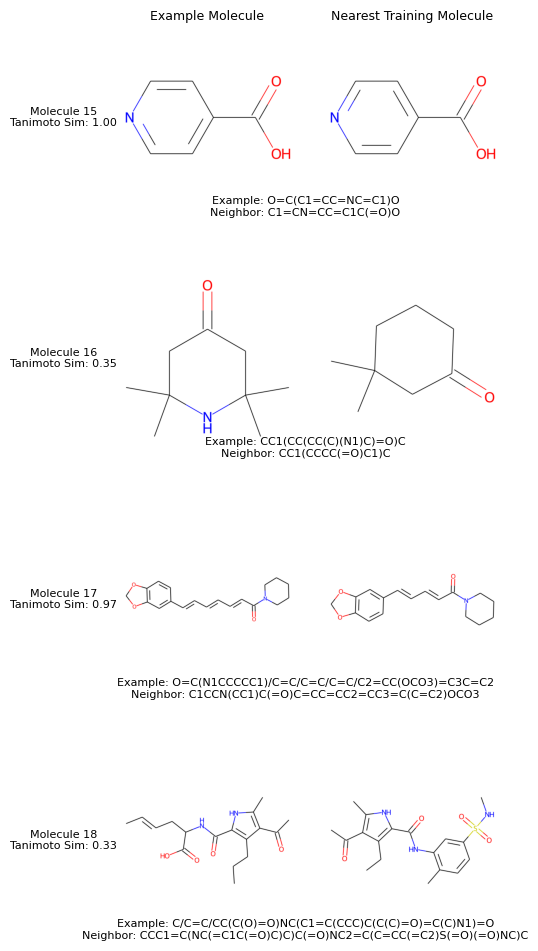

In [35]:
# Import pil image
save_mol_folder = save_folder / "mols_temp"
save_mol_folder.mkdir(exist_ok=True, parents=True)
# Draw a grid with each molecule, its nearest neighbor, and max sim using the df above
num_mols = len(df)

# Create a grid of num_mols rows and 3 columns
# Make 3 columsn with num mols rows, but make the first column smaller
fig, axes = plt.subplots(num_mols, 3, figsize=(3*2, num_mols*3), 
                         gridspec_kw={"width_ratios": [0.3, 1, 1]})


# Loop over the axes rows
for i, ax in enumerate(axes):
    # Get the smi and nearest smi
    smi = df.loc[i, "smi"]
    max_sim_smi = df.loc[i, "max_sim_smi"]
    # Get the mols
    mol = smi_to_mol[smi]
    max_sim_mol = Chem.MolFromSmiles(max_sim_smi)
    # Draw the molecules as pdf!
    # export_mol(mol, save_mol_folder / f"mol_{i+1}.pdf")
    # export_mol(max_sim_mol, save_mol_folder / f"mol_{i+1}_nn.pdf")

    # Draw high res!!!
    Draw.MolToFile(mol, str(save_mol_folder / f"mol_{i+1}.png"), size=(500, 500))
    Draw.MolToFile(max_sim_mol, str(save_mol_folder / f"mol_{i+1}_nn.png"), size=(500, 500))
    
    # Get num of molecule
    num = df.loc[i, "num"]
    # In the second box, plot the molecule
    # In the third box, plot the nn moleucle
    ax[1].imshow(np.array(Image.open(save_mol_folder / f"mol_{i+1}.png")))
    ax[2].imshow(np.array(Image.open(save_mol_folder / f"mol_{i+1}_nn.png")))
    
    # Add titles on first row
    if i == 0:
        ax[1].set_title(f"Example Molecule")
        ax[2].set_title(f"Nearest Training Molecule")

    # In the first box, add text to indicate the molecule example number and tanimoto similarity
    text_str =  f"Molecule {num}\nTanimoto Sim: {df.loc[i, 'max_sim']:.2f}"
    ax[0].text(0.5, 0.5, text_str, fontsize=8, ha='center', va='center')

    # underneath grids 1 and 2, write a single string with the smiles strings
    caption_str =  f"Example: {smi}\nNeighbor: {max_sim_smi}"
    ax[2].text(-0.1, 0, caption_str, fontsize=8, ha='center', va='center', transform=ax[2].transAxes)

    # Remove the ticks
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    # Remove the axes
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

# Save the figure
fig.savefig(save_folder / f"mols_neighbors_{neighb_name}.pdf", dpi=300, bbox_inches='tight')


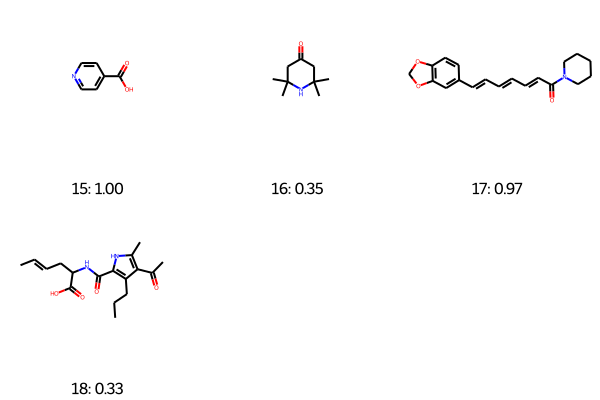

In [36]:
# Draw molecules with their number below and max similarity
smiles = list(smi_to_num.keys())
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
legend_text = [f"{smi_to_num[smi]}: {max_sim[i]:.2f}" for i, smi in enumerate(smiles)]
Draw.MolsToGridImage(mols, legends=legend_text, molsPerRow=3)